In [36]:
import joblib
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import time
from tkinter import *
from tkinter import filedialog
from tqdm import tqdm
from tqdm import notebook
import itertools
import math

In [37]:
def adp_filt(currdf: object, pose):
    lIndex = []
    xIndex = []
    yIndex = []
    currdf = np.array(currdf[1:])
    for header in pose:
        if currdf[0][header + 1] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header + 1] == "x":
            xIndex.append(header)
        elif currdf[0][header + 1] == "y":
            yIndex.append(header)
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[1:, np.array(xIndex)]
    datay = curr_df1[1:, np.array(yIndex)]
    data_lh = curr_df1[1:, np.array(lIndex)]
    currdf_filt = np.zeros((datax.shape[0], (datax.shape[1]) * 2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = b[rise_a[0][0]]
        else:
            llh = b[rise_a[0][1]]
        #llh=0
        data_lh_float = data_lh[:, x].astype(np.float)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        currdf_filt[0, (2 * x):(2 * x + 2)] = np.hstack([datax[0, x], datay[0, x]])
        for i in range(1, data_lh.shape[0]):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt)
    currdf_filt = currdf_filt.astype(np.float)
    return currdf_filt, perc_rect

def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg

## load deeplabcut csv

In [38]:
# Create Tk root
root = Tk()

# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles = filedialog.askopenfilename(multiple=True, title='load deeplabcut csv')
    
%gui tk

In [28]:
# convert to dataframe for all files
df_all = []
for f in range(len(infiles)):
    df_all.append(pd.read_csv(infiles[f], low_memory=False))

## filter based on likelihood

In [29]:
processed_input_data = []
for f in range(len(df_all)):
    csv_array_filtered, perc_filtered = adp_filt(df_all[f], np.arange(18))
    # making it into a list, feature extraction code works with multiple files in a list
    processed_input_data.append(csv_array_filtered)

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\Yttri-Lab\AppData\Local\Temp\ipykernel_396404\1606317399.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a, b = np.histogram(data_lh[1:, x].astype(np.float))
C:\Users\Yttri-Lab\AppData\Local\Temp\ipykernel_396404\1606317399.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_lh_floa

## feature extraction

In [30]:
features = []
framerate = 30
window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
f = []
for n in tqdm(range(len(processed_input_data))):
    data_n_len = len(processed_input_data[n])
    dxy_list = []
    disp_list = []
    for r in range(data_n_len):
        if r < data_n_len - 1:
            disp = []
            for c in range(0, processed_input_data[n].shape[1], 2):
                disp.append(
                    np.linalg.norm(processed_input_data[n][r + 1, c:c + 2] -
                                   processed_input_data[n][r, c:c + 2]))
            disp_list.append(disp)
        dxy = []
        for i, j in itertools.combinations(range(0, processed_input_data[n].shape[1], 2), 2):
            dxy.append(processed_input_data[n][r, i:i + 2] -
                       processed_input_data[n][r, j:j + 2])
        dxy_list.append(dxy)
    disp_r = np.array(disp_list)
    dxy_r = np.array(dxy_list)
    disp_boxcar = []
    dxy_eu = np.zeros([data_n_len, dxy_r.shape[1]])
    ang = np.zeros([data_n_len - 1, dxy_r.shape[1]])
    dxy_boxcar = []
    ang_boxcar = []
    for l in range(disp_r.shape[1]):
        disp_boxcar.append(boxcar_center(disp_r[:, l], window))
        # disp_boxcar.append(disp_r[:, l])
    for k in range(dxy_r.shape[1]):
        for kk in range(data_n_len):
            dxy_eu[kk, k] = np.linalg.norm(dxy_r[kk, k, :])
            if kk < data_n_len - 1:
                b_3d = np.hstack([dxy_r[kk + 1, k, :], 0])
                a_3d = np.hstack([dxy_r[kk, k, :], 0])
                c = np.cross(b_3d, a_3d)
                ang[kk, k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                    math.atan2(np.linalg.norm(c),
                                               np.dot(dxy_r[kk, k, :], dxy_r[kk + 1, k, :])))
        
        dxy_boxcar.append(boxcar_center(dxy_eu[:, k], window))
        ang_boxcar.append(boxcar_center(ang[:, k], window))
        # dxy_boxcar.append(dxy_eu[:, k])
        # ang_boxcar.append(ang[:, k])
    disp_feat = np.array(disp_boxcar)
    dxy_feat = np.array(dxy_boxcar)
    ang_feat = np.array(ang_boxcar)
    f.append(np.vstack((dxy_feat[:, 1:], ang_feat, disp_feat)))
    
for m in range(0, len(f)):
    f_integrated = np.zeros(len(processed_input_data[m]))
    for k in range(round(framerate / 10), len(f[m][0]), round(framerate / 10)):
        if k > round(framerate / 10):
            f_integrated = np.concatenate(
                (f_integrated.reshape(f_integrated.shape[0], f_integrated.shape[1]),
                np.hstack((np.mean((f[m][0:dxy_feat.shape[0],
                                         range(k - round(framerate / 10), k)]), axis=1),
                           np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                                        range(k - round(framerate / 10), k)]), axis=1)
                          )).reshape(len(f[0]), 1)), axis=1
                )
        else:
            f_integrated = np.hstack(
                (np.mean((f[m][0:dxy_feat.shape[0], range(k - round(framerate / 10), k)]), axis=1),
                 np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                              range(k - round(framerate / 10), k)]), axis=1))).reshape(len(f[0]), 1)
            
    features.append(f_integrated)
    
    #if m > 0:
    #     features = np.concatenate((features, f_integrated), axis=1)
    # else:
    #     features = f_integrated"
   

C:\Users\Yttri-Lab\AppData\Local\Temp\ipykernel_396404\1600903588.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
100%|██████████| 1/1 [01:55<00:00, 115.58s/it]


In [31]:
# If on Yttri Lab: Uncomment this one! 
#with open(r'C:\Users\Yttri-Lab\Desktop\D on Server (NoMachine)\DeepLabStream\iterX_usable_new.sav', 'rb') as fr:

#if using Z drive: uncomment this one! 
with open(r'Z:\temp\iterX_usable_new.sav', 'rb') as fr:
    
# If on local: Uncomment this one! 
#with open('/Volumes/yttri/temp/iterX_usable_new.sav', 'rb') as fr: 
    random_forest_sav = joblib.load(fr)
    clf = random_forest_sav[0]

C:\Users\Yttri-Lab\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Yttri-Lab\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [32]:
predictions = [clf.predict(features[f].T) for f in tqdm(range(len(features)))]

100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


In [33]:
len(predictions)

1

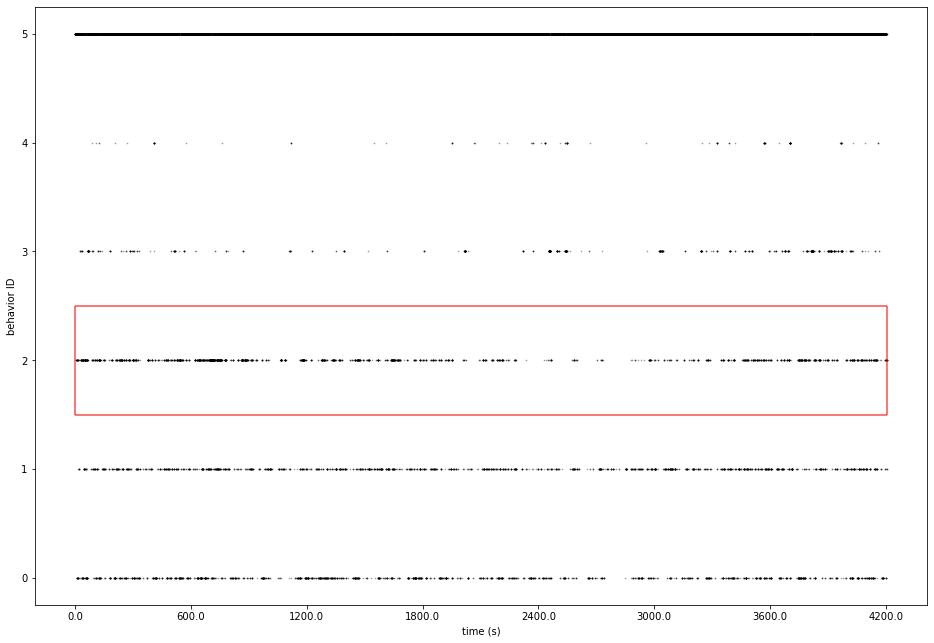

In [34]:
# class 1 and 2 are turns
class_of_interest=2
jitter = 0.5
rows = len(predictions)
cols = 1
fig, ax = plt.subplots(rows, cols, figsize=(16, 11))
for row in range(rows):
    if rows == 1:
        ax.hlines(class_of_interest-jitter, 0, len(predictions[row]), 'r', alpha=0.7)
        ax.hlines(class_of_interest+jitter, 0, len(predictions[row]), 'r', alpha=0.7)
        ax.vlines(0-jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
        ax.vlines(len(predictions[row])+jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
        ax.scatter(np.arange(len(predictions[row])), predictions[row], s=0.5, color='k', alpha=0.3)
        ax.set_xticks(np.arange(0, len(predictions[row]), 6000))
        ax.set_xticklabels(np.arange(0, len(predictions[row])/10, 600))
        ax.set_ylabel('behavior ID')
        ax.set_xlabel('time (s)')
    else:
        try:
            ax[row].set_title(f'vid{infiles[row].rpartition("DLC")[0].rpartition("/")[2].rpartition(" 0-")[2]}')
            ax[row].hlines(class_of_interest-jitter, 0, len(predictions[row]), 'r', alpha=0.7)
            ax[row].hlines(class_of_interest+jitter, 0, len(predictions[row]), 'r', alpha=0.7)
            ax[row].vlines(0-jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
            ax[row].vlines(len(predictions[row])+jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
            ax[row].scatter(np.arange(len(predictions[row])), predictions[row], s=0.5, color='k', alpha=0.3)
            ax[row].set_xticks(np.arange(0, len(predictions[row]), 6000))
            ax[row].set_xticklabels(np.arange(0, len(predictions[row])/10, 600))
            ax[row].set_ylabel('behavior ID')
            ax[row].set_xlabel('time (s)')
        except:
            pass
fig.savefig('./test.svg', dpi=600)


In [35]:
for f in range(len(infiles)):
    fileoutname = str.join('', (infiles[f].rpartition('DLC')[0], '_posthoc-predictions.npy'))
    np.save(fileoutname, predictions[f])